In [2]:
!pip install copulas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 629.7 kB/s eta 0:00:00


1/1 [==============================] - 1s 854ms/step


1/1 [==============================] - 1s 798ms/step


1/1 [==============================] - 1s 858ms/step
Total P&L by Maturity:
1 Mo    -0.303551
2 Mo     -0.16941
3 Mo     6.241824
4 Mo     0.789583
6 Mo    -1.422649
1 Yr    -2.099851
2 Yr    -0.114557
3 Yr     0.029741
5 Yr    -0.070687
7 Yr     0.179026
10 Yr    0.256188
20 Yr    0.178165
30 Yr    0.017201
dtype: object


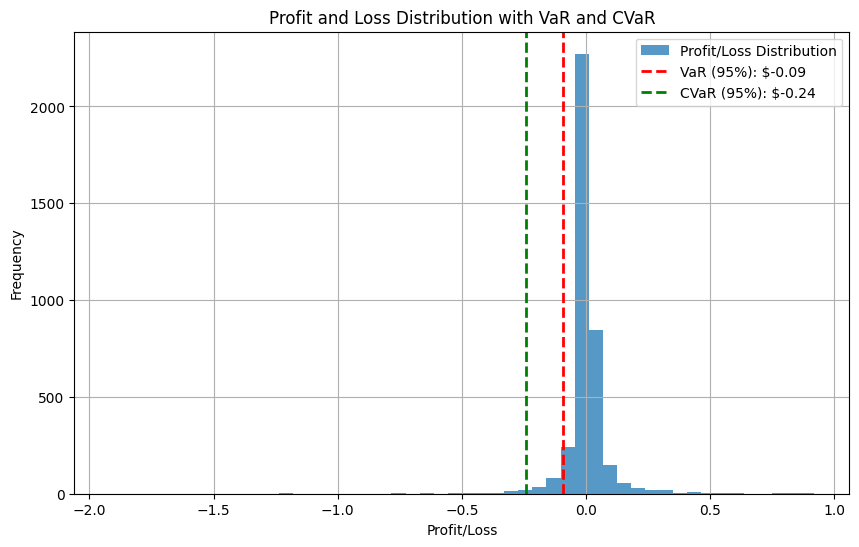

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt

# Function to calculate bond prices including coupon payments
def calculate_bond_price(face_value, annual_yield, years_to_maturity, coupon_rate, pay_freq):
    if years_to_maturity <= 1:
        periods = years_to_maturity
        discount_rate = annual_yield
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
        coupon_pv = 0
    else:
        annual_coupon = face_value * coupon_rate
        coupon_payment = annual_coupon / pay_freq
        discount_rate = annual_yield / pay_freq
        periods = int(years_to_maturity * pay_freq)
        coupon_pv = sum(coupon_payment / ((1 + discount_rate) ** period) for period in range(1, periods + 1))
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
    return coupon_pv + face_value_pv

# Load datasets
data_2023 = pd.read_csv('daily-treasury-rates.csv')
data_2024 = pd.read_csv('daily-treasury-rates-2.csv')

# Concatenate and sort the data
data = pd.concat([data_2023, data_2024])
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

# Define years to maturity based on column names
column_to_maturity = {
    '1 Mo': 1/12, '2 Mo': 2/12, '3 Mo': 3/12, '4 Mo': 4/12, '6 Mo': 6/12,
    '1 Yr': 1, '2 Yr': 2, '3 Yr': 3, '5 Yr': 5, '7 Yr': 7, '10 Yr': 10, '20 Yr': 20, '30 Yr': 30
}
maturity_years = [column_to_maturity[col] for col in data.columns]

def prepare_data(data, look_back=30):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_data)
    X, y = [], []
    for i in range(len(principal_components) - look_back):
        X.append(principal_components[i:i + look_back])
        y.append(principal_components[i + look_back])
    X, y = np.array(X), np.array(y)
    return X, y, pca, scaler

def train_lstm(X, y):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(X.shape[2]))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, batch_size=32, verbose=0)
    return model

profits_losses = pd.DataFrame(index=data.index[31:], columns=data.columns)
look_back = 30
face_value = 100
coupon_rate = 0.03  # Assume a 3% annual coupon rate
payment_frequency = 2  # Semi-annual payments

for start in range(len(data) - look_back - 1):
    current_data = data.iloc[start:start + look_back]
    X, y, pca, scaler = prepare_data(current_data, look_back - 1)
    model = train_lstm(X, y)
    next_day_pcs = model.predict(X[-1].reshape(1, -1, 3))
    predicted_rates = scaler.inverse_transform(pca.inverse_transform(next_day_pcs)).flatten()
    actual_rates = data.iloc[start + look_back - 1].values
    actual_rates_1 = data.iloc[start + look_back].values
    prices_30th = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates)]
    prices_31st = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates_1)]
    profits = np.where(predicted_rates < actual_rates,
                       np.array(prices_31st) - np.array(prices_30th),
                       np.array(prices_30th) - np.array(prices_31st))
    profits_losses.iloc[start] = profits

# Summarize results
total_pnl = profits_losses.sum()
print("Total P&L by Maturity:")
print(total_pnl)

# Calculate VaR and CVaR
confidence_level = 0.95
flattened_pnl = profits_losses.values.flatten()
var = np.percentile(flattened_pnl, (1 - confidence_level) * 100)
cvar = flattened_pnl[flattened_pnl <= var].mean()

# Plotting the distribution of profits/losses and marking the VaR and CVaR
plt.figure(figsize=(10, 6))
plt.hist(flattened_pnl, bins=50, alpha=0.75, label='Profit/Loss Distribution')
plt.axvline(x=var, color='r', linestyle='dashed', linewidth=2, label=f'VaR (95%): ${var:.2f}')
plt.axvline(x=cvar, color='g', linestyle='dashed', linewidth=2, label=f'CVaR (95%): ${cvar:.2f}')
plt.title('Profit and Loss Distribution with VaR and CVaR')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 1s 773ms/step


1/1 [==============================] - 1s 765ms/step


1/1 [==============================] - 1s 794ms/step
Total P&L by Maturity:
1 Mo     1.248541
2 Mo     0.803415
3 Mo     3.916505
4 Mo     0.780307
6 Mo     2.526977
1 Yr     1.560726
2 Yr     0.336758
3 Yr     0.402747
5 Yr     0.180697
7 Yr    -0.090963
10 Yr    0.156374
20 Yr     0.02751
30 Yr   -0.048492
dtype: object


<ipython-input-4-e12c921ea9f7>:96: RuntimeWarning: invalid value encountered in less_equal
  cvar = flattened_pnl[flattened_pnl <= var].mean()
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


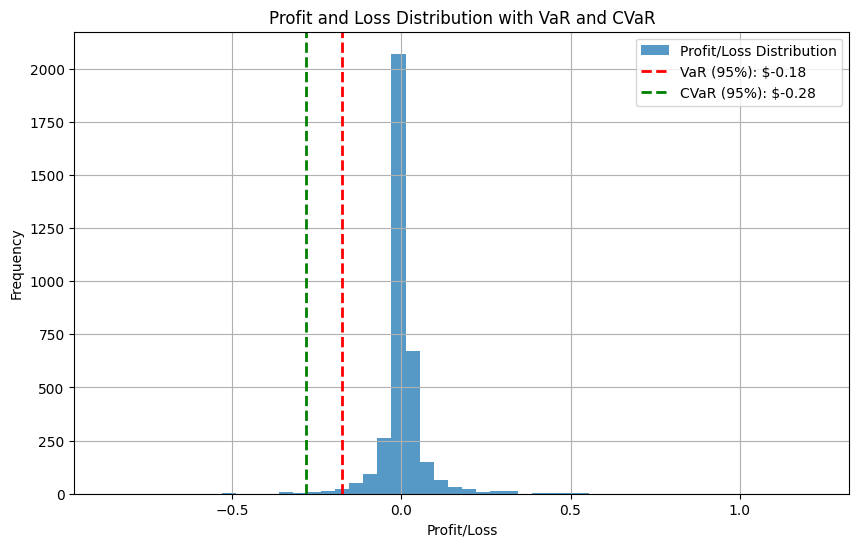

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt

# Function to calculate bond prices including coupon payments
def calculate_bond_price(face_value, annual_yield, years_to_maturity, coupon_rate, pay_freq):
    if years_to_maturity <= 1:
        periods = years_to_maturity
        discount_rate = annual_yield
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
        coupon_pv = 0
    else:
        annual_coupon = face_value * coupon_rate
        coupon_payment = annual_coupon / pay_freq
        discount_rate = annual_yield / pay_freq
        periods = int(years_to_maturity * pay_freq)
        coupon_pv = sum(coupon_payment / ((1 + discount_rate) ** period) for period in range(1, periods + 1))
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
    return coupon_pv + face_value_pv

# Load datasets
data_2023 = pd.read_csv('daily-treasury-rates.csv')
data_2024 = pd.read_csv('daily-treasury-rates-2.csv')

# Concatenate and sort the data
data = pd.concat([data_2023, data_2024])
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

# Define years to maturity based on column names
column_to_maturity = {
    '1 Mo': 1/12, '2 Mo': 2/12, '3 Mo': 3/12, '4 Mo': 4/12, '6 Mo': 6/12,
    '1 Yr': 1, '2 Yr': 2, '3 Yr': 3, '5 Yr': 5, '7 Yr': 7, '10 Yr': 10, '20 Yr': 20, '30 Yr': 30
}
maturity_years = [column_to_maturity[col] for col in data.columns]

def prepare_data(data, look_back=30):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_data)
    X, y = [], []
    for i in range(len(principal_components) - look_back):
        X.append(principal_components[i:i + look_back])
        y.append(principal_components[i + look_back])
    X, y = np.array(X), np.array(y)
    return X, y, pca, scaler

def train_lstm(X, y):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(X.shape[2]))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, batch_size=32, verbose=0)
    return model

profits_losses = pd.DataFrame(index=data.index[31:], columns=data.columns)
look_back = 60
face_value = 100
coupon_rate = 0.03  # Assume a 3% annual coupon rate
payment_frequency = 2  # Semi-annual payments

for start in range(len(data) - look_back - 1):
    current_data = data.iloc[start:start + look_back]
    X, y, pca, scaler = prepare_data(current_data, look_back - 1)
    model = train_lstm(X, y)
    next_day_pcs = model.predict(X[-1].reshape(1, -1, 3))
    predicted_rates = scaler.inverse_transform(pca.inverse_transform(next_day_pcs)).flatten()
    actual_rates = data.iloc[start + look_back - 1].values
    actual_rates_1 = data.iloc[start + look_back].values
    prices_30th = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates)]
    prices_31st = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates_1)]
    profits = np.where(predicted_rates < actual_rates,
                       np.array(prices_31st) - np.array(prices_30th),
                       np.array(prices_30th) - np.array(prices_31st))
    profits_losses.iloc[start] = profits

# Summarize results
total_pnl = profits_losses.sum()
print("Total P&L by Maturity:")
print(total_pnl)

# Calculate VaR and CVaR
confidence_level = 0.95
flattened_pnl = profits_losses.values.flatten()
var = np.percentile(flattened_pnl, (1 - confidence_level) * 100)
cvar = flattened_pnl[flattened_pnl <= var].mean()

# Plotting the distribution of profits/losses and marking the VaR and CVaR
plt.figure(figsize=(10, 6))
plt.hist(flattened_pnl, bins=50, alpha=0.75, label='Profit/Loss Distribution')
plt.axvline(x=var, color='r', linestyle='dashed', linewidth=2, label=f'VaR (95%): ${var:.2f}')
plt.axvline(x=cvar, color='g', linestyle='dashed', linewidth=2, label=f'CVaR (95%): ${cvar:.2f}')
plt.title('Profit and Loss Distribution with VaR and CVaR')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 1s 789ms/step


1/1 [==============================] - 1s 781ms/step


1/1 [==============================] - 1s 845ms/step
Total P&L by Maturity:
1 Mo    -1.025411
2 Mo     1.238549
3 Mo     4.102749
4 Mo    -0.149369
6 Mo     0.078155
1 Yr    -2.841529
2 Yr    -0.346179
3 Yr     0.407183
5 Yr    -0.274624
7 Yr    -0.212089
10 Yr    0.294065
20 Yr    0.018458
30 Yr    0.008944
dtype: object


<ipython-input-1-55aa0fc386ac>:96: RuntimeWarning: invalid value encountered in less_equal
  cvar = flattened_pnl[flattened_pnl <= var].mean()
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


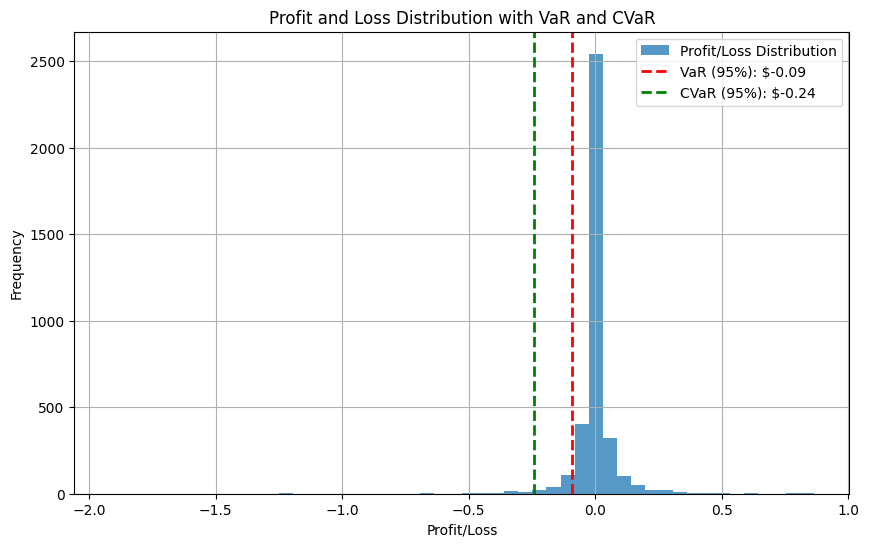

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt

# Function to calculate bond prices including coupon payments
def calculate_bond_price(face_value, annual_yield, years_to_maturity, coupon_rate, pay_freq):
    if years_to_maturity <= 1:
        periods = years_to_maturity
        discount_rate = annual_yield
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
        coupon_pv = 0
    else:
        annual_coupon = face_value * coupon_rate
        coupon_payment = annual_coupon / pay_freq
        discount_rate = annual_yield / pay_freq
        periods = int(years_to_maturity * pay_freq)
        coupon_pv = sum(coupon_payment / ((1 + discount_rate) ** period) for period in range(1, periods + 1))
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
    return coupon_pv + face_value_pv

# Load datasets
data_2023 = pd.read_csv('daily-treasury-rates.csv')
data_2024 = pd.read_csv('daily-treasury-rates-2.csv')

# Concatenate and sort the data
data = pd.concat([data_2023, data_2024])
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

# Define years to maturity based on column names
column_to_maturity = {
    '1 Mo': 1/12, '2 Mo': 2/12, '3 Mo': 3/12, '4 Mo': 4/12, '6 Mo': 6/12,
    '1 Yr': 1, '2 Yr': 2, '3 Yr': 3, '5 Yr': 5, '7 Yr': 7, '10 Yr': 10, '20 Yr': 20, '30 Yr': 30
}
maturity_years = [column_to_maturity[col] for col in data.columns]

def prepare_data(data, look_back=30):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_data)
    X, y = [], []
    for i in range(len(principal_components) - look_back):
        X.append(principal_components[i:i + look_back])
        y.append(principal_components[i + look_back])
    X, y = np.array(X), np.array(y)
    return X, y, pca, scaler

def train_lstm(X, y):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(X.shape[2]))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, batch_size=32, verbose=0)
    return model

profits_losses = pd.DataFrame(index=data.index[31:], columns=data.columns)
look_back = 45
face_value = 100
coupon_rate = 0.03  # Assume a 3% annual coupon rate
payment_frequency = 2  # Semi-annual payments

for start in range(len(data) - look_back - 1):
    current_data = data.iloc[start:start + look_back]
    X, y, pca, scaler = prepare_data(current_data, look_back - 1)
    model = train_lstm(X, y)
    next_day_pcs = model.predict(X[-1].reshape(1, -1, 3))
    predicted_rates = scaler.inverse_transform(pca.inverse_transform(next_day_pcs)).flatten()
    actual_rates = data.iloc[start + look_back - 1].values
    actual_rates_1 = data.iloc[start + look_back].values
    prices_30th = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates)]
    prices_31st = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates_1)]
    profits = np.where(predicted_rates < actual_rates,
                       np.array(prices_31st) - np.array(prices_30th),
                       np.array(prices_30th) - np.array(prices_31st))
    profits_losses.iloc[start] = profits

# Summarize results
total_pnl = profits_losses.sum()
print("Total P&L by Maturity:")
print(total_pnl)

# Calculate VaR and CVaR
confidence_level = 0.95
flattened_pnl = profits_losses.values.flatten()
var = np.percentile(flattened_pnl, (1 - confidence_level) * 100)
cvar = flattened_pnl[flattened_pnl <= var].mean()

# Plotting the distribution of profits/losses and marking the VaR and CVaR
plt.figure(figsize=(10, 6))
plt.hist(flattened_pnl, bins=50, alpha=0.75, label='Profit/Loss Distribution')
plt.axvline(x=var, color='r', linestyle='dashed', linewidth=2, label=f'VaR (95%): ${var:.2f}')
plt.axvline(x=cvar, color='g', linestyle='dashed', linewidth=2, label=f'CVaR (95%): ${cvar:.2f}')
plt.title('Profit and Loss Distribution with VaR and CVaR')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 1s 782ms/step


1/1 [==============================] - 1s 895ms/step


1/1 [==============================] - 1s 918ms/step
Total P&L by Maturity:
1 Mo     1.450743
2 Mo     2.508033
3 Mo     2.571803
4 Mo    -0.284952
6 Mo     1.460453
1 Yr      0.58542
2 Yr     0.882772
3 Yr     0.409704
5 Yr     0.146375
7 Yr     0.337073
10 Yr    0.069121
20 Yr   -0.120593
30 Yr   -0.032716
dtype: object


<ipython-input-3-0990cdfc724f>:96: RuntimeWarning: invalid value encountered in less_equal
  cvar = flattened_pnl[flattened_pnl <= var].mean()
<ipython-input-3-0990cdfc724f>:96: RuntimeWarning: Mean of empty slice.
  cvar = flattened_pnl[flattened_pnl <= var].mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


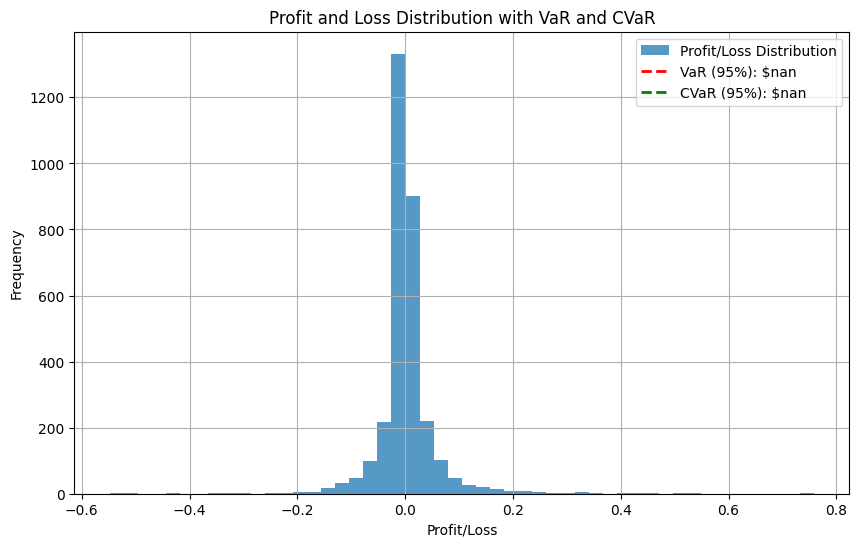

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt

# Function to calculate bond prices including coupon payments
def calculate_bond_price(face_value, annual_yield, years_to_maturity, coupon_rate, pay_freq):
    if years_to_maturity <= 1:
        periods = years_to_maturity
        discount_rate = annual_yield
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
        coupon_pv = 0
    else:
        annual_coupon = face_value * coupon_rate
        coupon_payment = annual_coupon / pay_freq
        discount_rate = annual_yield / pay_freq
        periods = int(years_to_maturity * pay_freq)
        coupon_pv = sum(coupon_payment / ((1 + discount_rate) ** period) for period in range(1, periods + 1))
        face_value_pv = face_value / ((1 + discount_rate) ** periods)
    return coupon_pv + face_value_pv

# Load datasets
data_2023 = pd.read_csv('daily-treasury-rates.csv')
data_2024 = pd.read_csv('daily-treasury-rates-2.csv')

# Concatenate and sort the data
data = pd.concat([data_2023, data_2024])
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

# Define years to maturity based on column names
column_to_maturity = {
    '1 Mo': 1/12, '2 Mo': 2/12, '3 Mo': 3/12, '4 Mo': 4/12, '6 Mo': 6/12,
    '1 Yr': 1, '2 Yr': 2, '3 Yr': 3, '5 Yr': 5, '7 Yr': 7, '10 Yr': 10, '20 Yr': 20, '30 Yr': 30
}
maturity_years = [column_to_maturity[col] for col in data.columns]

def prepare_data(data, look_back=30):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_data)
    X, y = [], []
    for i in range(len(principal_components) - look_back):
        X.append(principal_components[i:i + look_back])
        y.append(principal_components[i + look_back])
    X, y = np.array(X), np.array(y)
    return X, y, pca, scaler

def train_lstm(X, y):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(X.shape[2]))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, batch_size=32, verbose=0)
    return model

profits_losses = pd.DataFrame(index=data.index[31:], columns=data.columns)
look_back = 90
face_value = 100
coupon_rate = 0.03  # Assume a 3% annual coupon rate
payment_frequency = 2  # Semi-annual payments

for start in range(len(data) - look_back - 1):
    current_data = data.iloc[start:start + look_back]
    X, y, pca, scaler = prepare_data(current_data, look_back - 1)
    model = train_lstm(X, y)
    next_day_pcs = model.predict(X[-1].reshape(1, -1, 3))
    predicted_rates = scaler.inverse_transform(pca.inverse_transform(next_day_pcs)).flatten()
    actual_rates = data.iloc[start + look_back - 1].values
    actual_rates_1 = data.iloc[start + look_back].values
    prices_30th = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates)]
    prices_31st = [calculate_bond_price(face_value, rate, maturity_years[i], coupon_rate if maturity_years[i] > 1 else 0, payment_frequency)
                   for i, rate in enumerate(actual_rates_1)]
    profits = np.where(predicted_rates < actual_rates,
                       np.array(prices_31st) - np.array(prices_30th),
                       np.array(prices_30th) - np.array(prices_31st))
    profits_losses.iloc[start] = profits

# Summarize results
total_pnl = profits_losses.sum()
print("Total P&L by Maturity:")
print(total_pnl)

# Calculate VaR and CVaR
confidence_level = 0.95
flattened_pnl = profits_losses.values.flatten()
var = np.percentile(flattened_pnl, (1 - confidence_level) * 100)
cvar = flattened_pnl[flattened_pnl <= var].mean()

# Plotting the distribution of profits/losses and marking the VaR and CVaR
plt.figure(figsize=(10, 6))
plt.hist(flattened_pnl, bins=50, alpha=0.75, label='Profit/Loss Distribution')
plt.axvline(x=var, color='r', linestyle='dashed', linewidth=2, label=f'VaR (95%): ${var:.2f}')
plt.axvline(x=cvar, color='g', linestyle='dashed', linewidth=2, label=f'CVaR (95%): ${cvar:.2f}')
plt.title('Profit and Loss Distribution with VaR and CVaR')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()